# Import statements

In [1]:
from pytao import Tao
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
from os import path,environ
import pandas as pd
import random

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles

from plotNMM import plotNMM, slicePlotNMM
from IPython.display import display

from UTILITY_linacPhaseAndAmplitude import getLinacMatchStrings, setLinacPhase, setLinacGradientAuto
from UTILITY_modifyAndSaveInputBeam import modifyAndSaveInputBeam

#needed for lattice_init
#%env FACET2_LATTICE /u/ar/dcesar/notebooks/facet_bmad
#%env FACET2_LATTICE /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample

import os
filePath = os.getcwd()
%env FACET2_LATTICE {filePath}

print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 

env: FACET2_LATTICE=/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample
Make sure enviornment was set!:   /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample


# Start tao

In [2]:
tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init -noplot'.format(environ['FACET2_LATTICE'])) 
#tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init'.format(environ['FACET2_LATTICE'])) 



## Load useful element lists

In [3]:
[L1MatchStrings, L2MatchStrings, L3MatchStrings, selectMarkers] = getLinacMatchStrings(tao)

# Plot single particle twiss

In [4]:
#Helper functions for single particle Twiss plots

def floorplan_sorter(ele):
    """
    ele is an element of a pandas dictionary made from the bmad floorplan (made to look like an elegant floorplan from my "elegant_helpers" file). This sorter parses the columns to make a "patch" for plotting purposes. See floorplan_patches().
    """
    if ele['ds']==0:
        ele['ds']=0.05
    s0=float(ele['s'])-float(ele['ds'])
    x=float(ele['X'])*2-0.5
    
    if (re.search('DRIF',ele.ElementType.upper())!=None)|(ele.ElementType.upper()=='MARK'):
        patchColor=None
        patch=None
    elif (re.search('BEND',ele.ElementType.upper())!=None)|(re.search('KICK',ele.ElementType.upper())!=None):
        patchColor='r'
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif re.search('XL',ele.ElementName.upper())!=None:
        patchColor=colorlist2[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'QUAD' in ele.ElementType.upper():
        patchColor=colorlist[2]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'SEXT' in ele.ElementType.upper():
        patchColor="#204337"
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'RFCW' in ele.ElementType.upper() or 'CAV' in ele.ElementType.upper():
        string_lst=['L3_10_50','L3_10_25','L2_10_25','L2_10_50','X1_Xband','L1_10_25','L1_9_25','L1_9_50'] #nonzero voltage
        if re.findall(r"(?=("+'|'.join(string_lst)+r"))",ele.ElementName)!=None:
            patchColor="#CD7F32"
            patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=0.5,color=patchColor,lw=0,ls=None)
    elif re.search('^UM',ele.ElementName)!=None:
        patchColor=colorlist[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    else:
        patchColor=None
        patch=None
        
    return patch

def floorplan_patches(floorplan,zbounds=None):
    """
    This function returns a list of patches to be plotted (patches) and a list of patches for the legend (leg_patches). If zbounds=[zmin,zmax] is given then the plot is restricted to the bounds. 
    
    Useage:
    
    fp=SDDS(0)
    fp.load(LCLS2scS.flr)
    __,floorplan=sdds2pd(fp)
    patches,leg_patches=flooplan_patches(floorplan,[3425,3750])
    """
    if zbounds==None:
        zbounds=[flooplan['s'].min(),flooplan['s'].max()]
    sFloor=floorplan.s.astype(dtype=float);
    sFloor=sFloor.values
    ii=0;
    patches=[];
    for index, ele in (floorplan.iloc[(sFloor>zbounds[0])&(sFloor<zbounds[1])]).iterrows():
        patches.append(floorplan_sorter(ele))
    
    quad_patch = mpatches.Patch(color=colorlist[2], label='Quad')
    sext_patch = mpatches.Patch(color="#204337", label='Linac')
    bend_patch = mpatches.Patch(color='red', label='Bend')
    leg_patches=[quad_patch,sext_patch,bend_patch];
    return patches,leg_patches
    
def floorplan_plot(ax_fp,floorplan,zmin=0,zmax=2000):  
    """
    This function plots "patches" for basic elements in the lattice. This can help identify what you're looking at in a "z-plot".
    """
    
    patches,leg_patches=floorplan_patches(floorplan,[zmin,zmax])

    for p in patches:
        if p!=None:
            ax_fp.add_patch(p)

    ax_fp.plot((zmin,zmax),(0,0),'k',alpha=0.0)
    ax_fp.tick_params(axis='x',direction='out',length=15,width=6,color='k',bottom=True)
    plt.yticks([])
    #ax_fp.set_ylim([-3,1])
    ax_fp.set_xlim([zmin,zmax])
    return ax_fp
    
def format_longitudinal_plot(fig):
    """
    This function helps format a "z-plot" by providing axes for the main plot and for the a floorplan_plot. It also plots the floorplan.
    """
    outer_grid=fig.add_gridspec(5,1,hspace=0)
    ax=fig.add_subplot(outer_grid[0:4,:])
    ax_fp=fig.add_subplot(outer_grid[4,:], sharex = ax)
    floorplan_plot(ax_fp,floorplan)
    plt.sca(ax)
    
    return ax, ax_fp 

In [5]:
elements=tao.lat_ele_list();

floorplan=pd.read_csv(
    io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), 
    sep="[\s\n]+",
    engine='python',
    names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True);

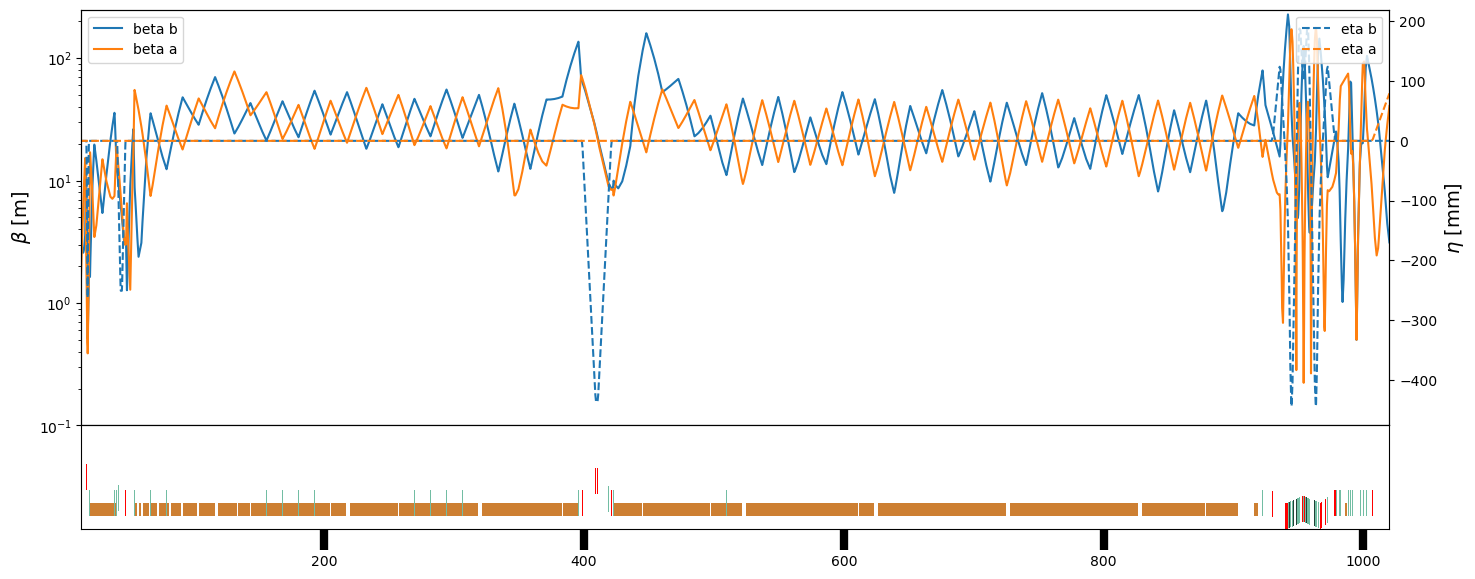

In [6]:
colorlist=['#982649', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']




#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])


fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=13
zmax=1020

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig('beamline',transparent=False,bbox_inches='tight', dpi=300)

# Beam construction

## Import beam

## Propagate to BEGBC20 

In [7]:
#numMacroParticles = 100000
#tao.cmd(f"set beam_init n_particle = {numMacroParticles}") # limit to 10k particles for now

#Change tracking start/end
#tao.cmd('set beam_init track_end = ENDDL10')
#tao.cmd('set beam_init track_end = PENT')
lastTrackedElement = "end"
tao.cmd(f'set beam_init track_end = {lastTrackedElement}')

#Can see present track_start and track_end values with `show beam`



#Optional: Enable CSR
tao.cmd(f'call {filePath}/bmad/models/f2_elec/scripts/Activate_CSR.tao')
#tao.cmd('csron')
tao.cmd('csroff')

[]

MFFF: 0.00016475395523757826


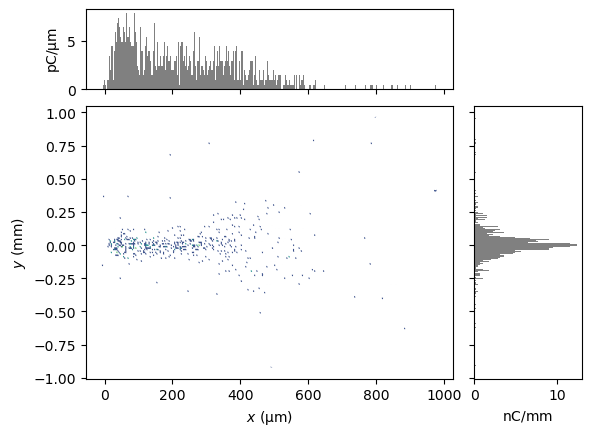

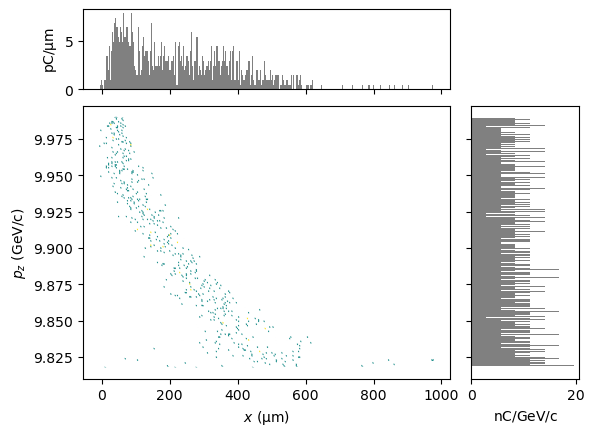

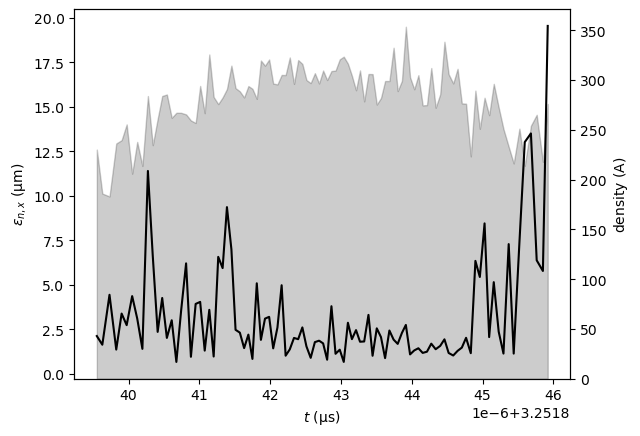

In [8]:
inputBeamFilePath = f'{filePath}/bmad/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights_driverOnly.h5'


modifyAndSaveInputBeam(
    inputBeamFilePath,
    numMacroParticles = 1000
)

tao.cmd(f'set beam_init position_file={filePath}/bmad/beams/activeBeamFile.h5')
tao.cmd('reinit beam')


# === Make changes to base lattice ===
tao.cmd('set ele L0BF PHI0 = 0') #DNT. "loadNominalValues_2Bunch.m" had this set to zero
tao.cmd('set ele L0BF VOLTAGE = 5.95e7') #DNT. Base value was 7.1067641E+07, new value set to change output energy to 125 MeV (down from 136.5 MeV)

#L1AssertPHI0 = -19 #DNT. "loadNominalValues_2Bunch.m" had this set to -19 degrees
setLinacPhase(        tao, L1MatchStrings, -19 ) 
setLinacGradientAuto( tao, L1MatchStrings, 0.335e9 - 0.125e9 ) 

#L2AssertPHI0 = -37 #DNT. "loadNominalValues_2Bunch.m" had this set to -37 degrees
setLinacPhase(        tao, L2MatchStrings, 0 ) 
setLinacGradientAuto( tao, L2MatchStrings, 4.5e9 - 0.335e9 )

setLinacPhase(        tao, L3MatchStrings, 0 )
setLinacGradientAuto( tao, L3MatchStrings, 10.0e9 - 4.5e9 )




tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation






PMFFF =  ParticleGroup(data=tao.bunch_data("MFFF"))

#print(f"BEGBC20: {PBEGBC20.norm_emit_x}")
#display(plotNMM(PBEGBC20, 'x', 'y', bins=300))
#display(plotNMM(PBEGBC20, 'x', 'pz', bins=300))
#display(slicePlotNMM(PBEGBC20, 'norm_emit_x',n_slice=100))

PMFFFSigmaX = PMFFF.std("x")
print(f"MFFF: {PMFFFSigmaX}")
display(plotNMM(PMFFF, 'x', 'y', bins=300))
display(plotNMM(PMFFF, 'x', 'pz', bins=300))
display(slicePlotNMM(PMFFF, 'norm_emit_x',n_slice=100))


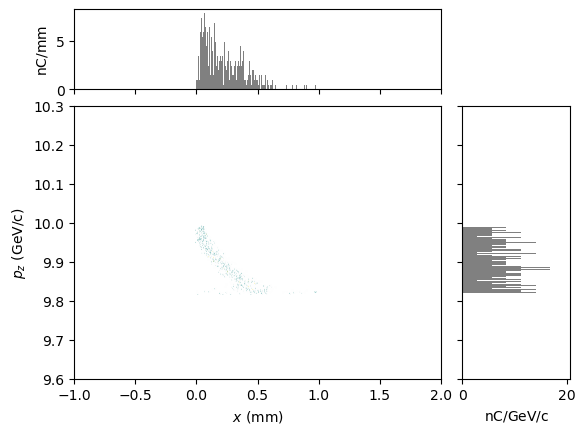

In [9]:
display(plotNMM(PMFFF, 'x', 'pz', bins=300, xlim = (-1e-3,2e-3), ylim = (9.6e9, 10.3e9)))

## A loop for idiots

94.17845673606111: -23, -35


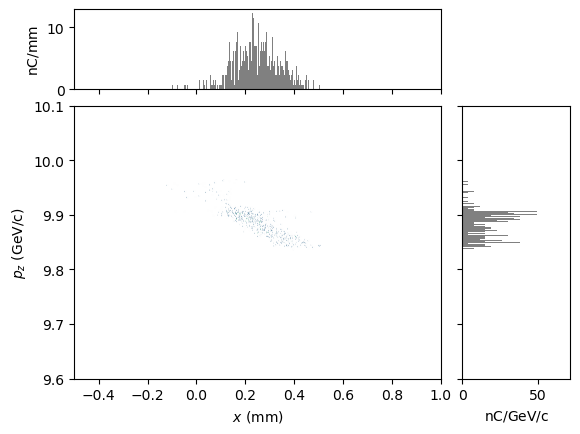

71.0607979551762: -23, -33


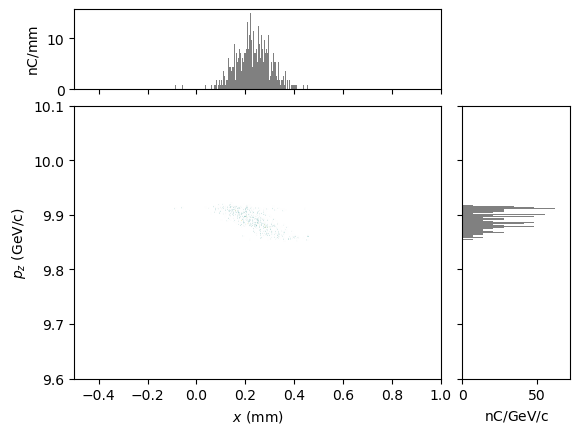

68.35098154288426: -23, -31


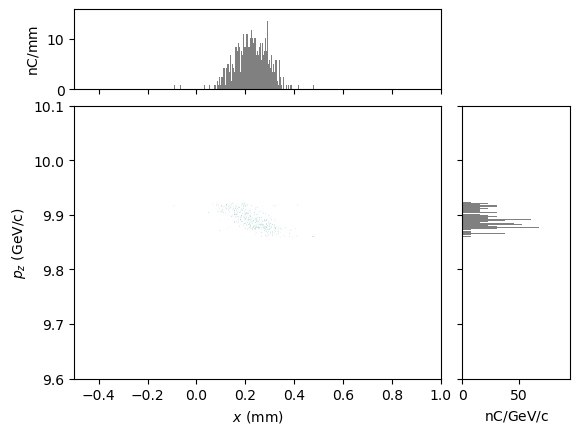

71.25281226184862: -23, -29


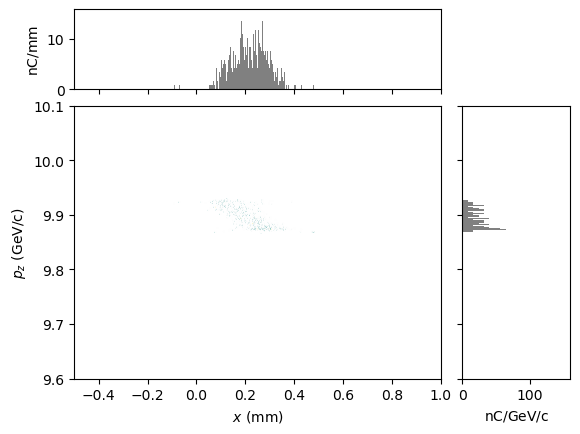

76.48139497939857: -23, -27


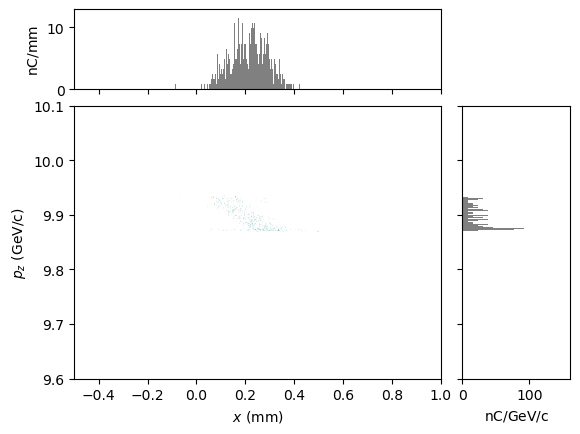

82.533086150025: -23, -25


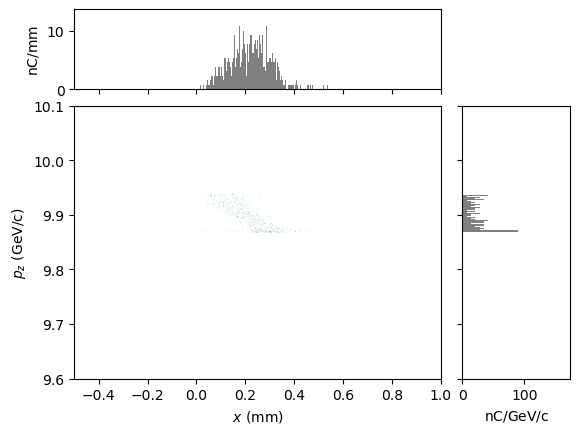

89.17015223910599: -23, -23


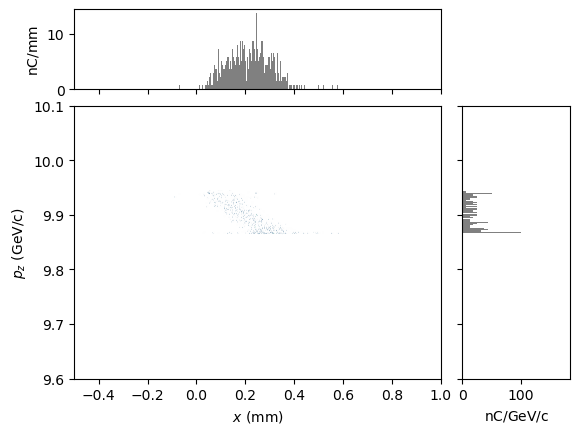

95.88028053919005: -23, -21


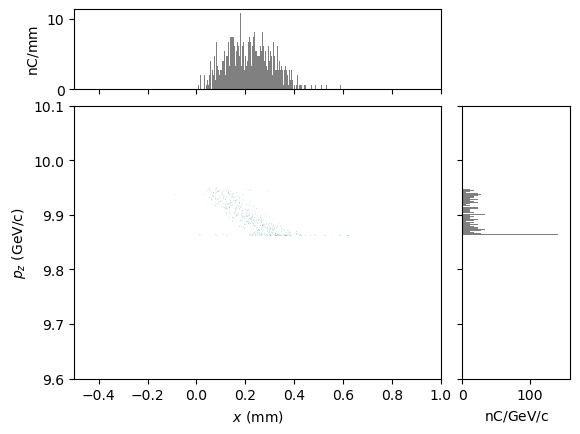

119.02761031496945: -21, -35


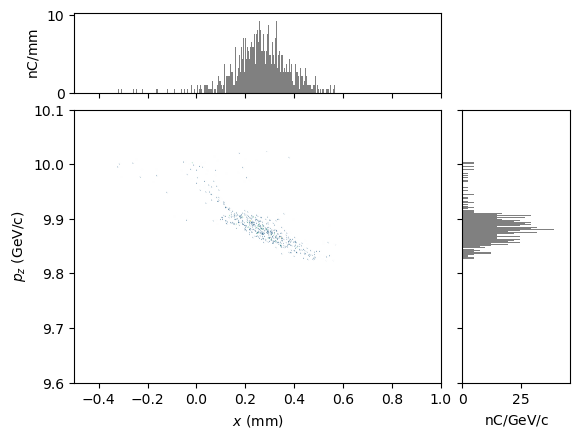

69.6336950218057: -21, -33


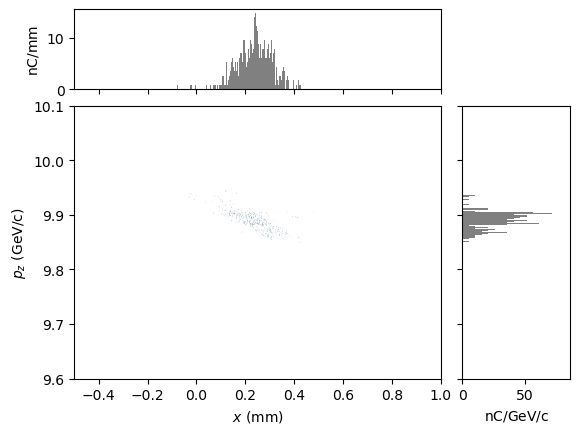

58.678375066836644: -21, -31


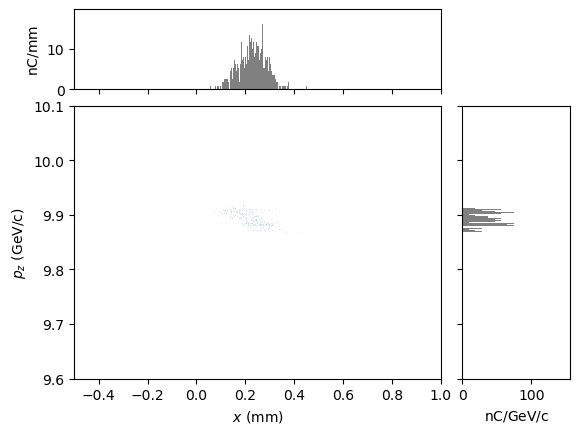

59.66359190282036: -21, -29


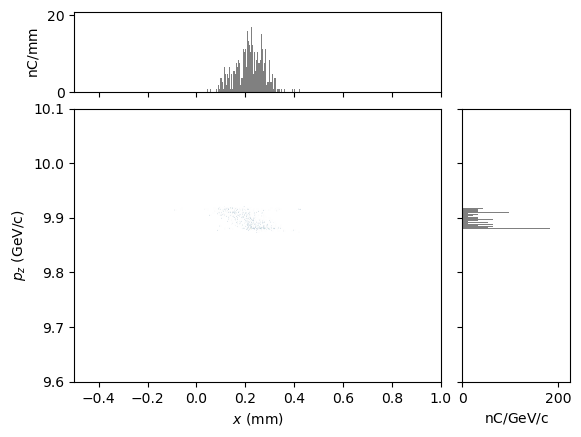

64.3065074709006: -21, -27


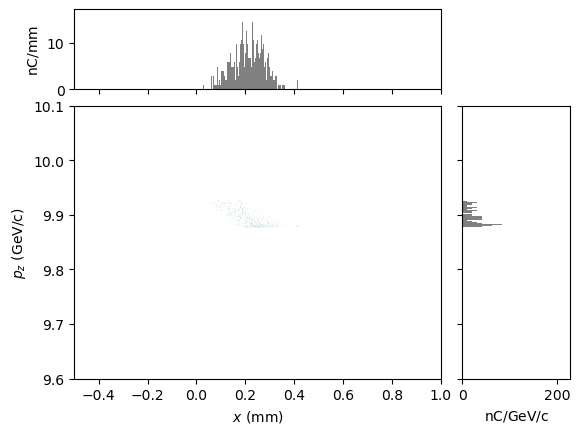

70.35096498540437: -21, -25


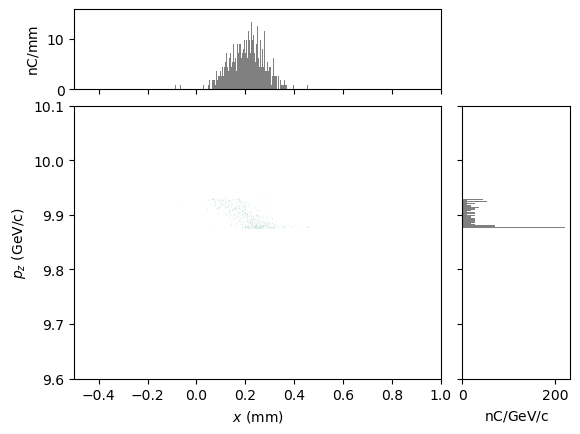

77.38181749635883: -21, -23


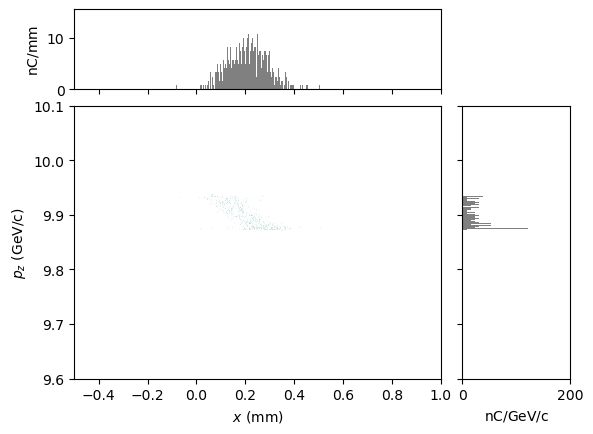

84.59677082075513: -21, -21


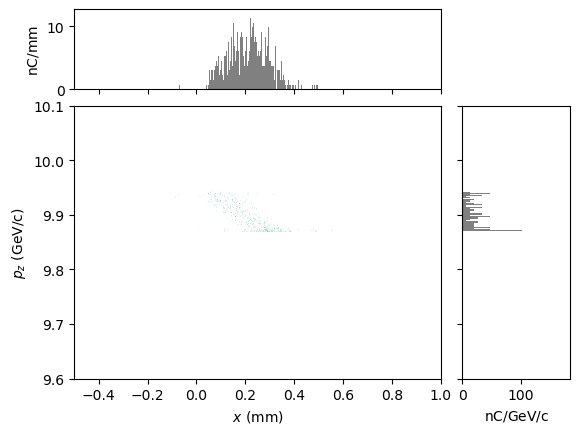

171.13921211341346: -19, -35


/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample/plotNMM.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**kwargs)


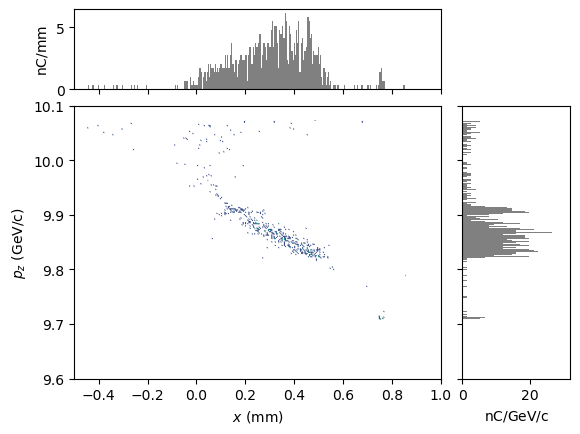

74.82923306233201: -19, -33


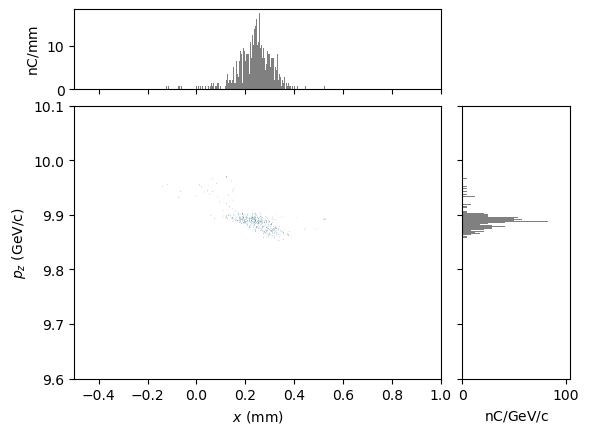


KeyboardInterrupt



In [10]:
for L1PhaseSet in np.arange(-23, -15, 2):
    for L2PhaseSet in np.arange(-35, -20, 2):
    #for L3EnergyCorrection in np.arange(0, 150e6, 25e6):
        #L2PhaseSet = -37
    
        
        # === Make changes to base lattice ===
        tao.cmd('set ele L0BF PHI0 = 0') #DNT. "loadNominalValues_2Bunch.m" had this set to zero
        tao.cmd('set ele L0BF VOLTAGE = 5.95e7') #DNT. Base value was 7.1067641E+07, new value set to change output energy to 125 MeV (down from 136.5 MeV)
        
        #L1AssertPHI0 = -19 #DNT. "loadNominalValues_2Bunch.m" had this set to -19 degrees
        setLinacPhase(        tao, L1MatchStrings, L1PhaseSet ) 
        setLinacGradientAuto( tao, L1MatchStrings, 0.335e9 - 0.125e9 ) 
        
        #L2AssertPHI0 = -37 #DNT. "loadNominalValues_2Bunch.m" had this set to -37 degrees
        setLinacPhase(        tao, L2MatchStrings, L2PhaseSet ) 
        setLinacGradientAuto( tao, L2MatchStrings, 4.5e9 - 0.335e9 )
        
        setLinacPhase(        tao, L3MatchStrings, 0 )
        setLinacGradientAuto( tao, L3MatchStrings, 10.0e9 - 4.5e9 )
        
        
        
        
        tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
        tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation
        
        
        
        
        
        
        PMFFF =  ParticleGroup(data=tao.bunch_data("MFFF"))
        
        #print(f"BEGBC20: {PBEGBC20.norm_emit_x}")
        #display(plotNMM(PBEGBC20, 'x', 'y', bins=300))
        #display(plotNMM(PBEGBC20, 'x', 'pz', bins=300))
        #display(slicePlotNMM(PBEGBC20, 'norm_emit_x',n_slice=100))
        
        PMFFFSigmaX = PMFFF.std("x")
        print(f"{1e6*PMFFFSigmaX}: {L1PhaseSet}, {L2PhaseSet}")
        #display(plotNMM(PMFFF, 'x', 'y', bins=300))
        display(plotNMM(PMFFF, 'x', 'pz', bins=300, xlim = (-0.5e-3,1e-3), ylim = (9.6e9, 10.1e9)))
        #display(slicePlotNMM(PMFFF, 'norm_emit_x',n_slice=100))
